# This solution uses Multi Layer Perceptron to predict values for the output 
<b>Importing all the required modules and retrieving the dataset as already provided in the problem</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import torch
from torch.autograd import Variable 
import warnings

In [2]:
# Download and unzip the dataset
urllib.request.urlretrieve('http://bit.ly/seismicml2019data',
                           'seismicml2019.zip')
zip_ref = zipfile.ZipFile('seismicml2019.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
# Load the data
models_train = np.load('seismicml2019_models_train.npy')
data_train = np.load('seismicml2019_data_train.npy')
data_test = np.load('seismicml2019_data_test.npy')

<b> Checking the input data distribution in below step</b>

Percentage of values between -3 to 3: 85.85 %
Median of the input data is 0.000671153306029737


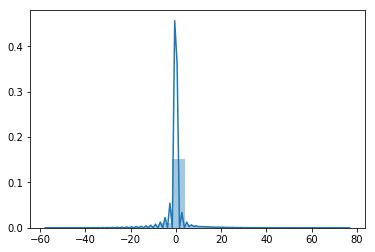

In [4]:
import seaborn as sns
warnings.filterwarnings("ignore")
sns.distplot(data_train.reshape(1,-1)[0], bins=24)
plot_val = data_train.flatten()
filtered_vals = plot_val[(plot_val>-3) & (plot_val<3)]
print("Percentage of values between -3 to 3: {:.2f} %".format(100*filtered_vals.shape[0]/plot_val.shape[0]))
print("Median of the input data is {}".format(np.median(data_train.reshape(1,-1)[0])))

<b>From above plot we can see that input values are all almost centred around the range of -3 to 3. Thus, we checked to see the percentage of these values which came out to be 89.12% as shown in above results. Thus, next we saw the distribution of this range to check underlying probability distribution of the input as shown below</b>

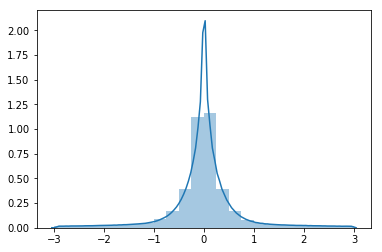

In [5]:
sns.distplot(filtered_vals, bins=24)
warnings.filterwarnings("ignore")

<b>As we know now that input is following the normal distribution we will use z-score to find outliers and use the median value to replace these values (which is 0)</b>

In [6]:
import numpy as np
import pandas as pd
def detect_outlier(data_1):
    outliers=[] #List with only outliers
    trimmed=[]   #List without outliers 
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for index,y in enumerate(data_1):
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append([index,y])
        else:
            trimmed.append(y)
    return outliers,trimmed

liers_train,trimmed1 = detect_outlier(data_train.reshape(1,-1)[0])
liers_out12,trimmed2 = detect_outlier(models_train.reshape(1,-1)[0])

In [7]:

print("Minimum value in outlier data {}".format(min([l[1] for l in liers_train])))
print("Maximum value in outlier data {}".format(max([l[1] for l in liers_train])))

print("Minimum value in correct data {}".format(min(trimmed1)))
print("Maximum value in correct data {}".format(max(trimmed1)))

###Thus, now we'll replace any value greater than 15.720298767089844 and less than 15.710599899291992 by median value(0) #####

flat = data_train.reshape(1,-1)
flat[0][flat[0]>15.720298767089844]=0
flat[0][flat[0]<-15.710599899291992]=0

flat = flat.reshape(9000,3,150)

print("Shape of data with treated outliers {}".format(flat.shape))

Minimum value in outlier data -57.580909729003906
Maximum value in outlier data 76.71263122558594
Minimum value in correct data -15.710599899291992
Maximum value in correct data 15.720298767089844
Shape of data with treated outliers (9000, 3, 150)


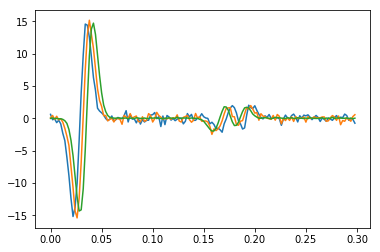

In [8]:
for recidx in range(3):
  plt.plot(np.arange(data_train[0].shape[-1])*0.002, data_train[0, recidx])

<b>As can be seen in above plot there is high correlation between the values that have been recorded from three depths. Thus, it makes sense to apply PCA and check if we can capture major variance in lesser number of dimensions. PCA has been applied for each sample separately considering each depth reading as 1 feature vector.</b>

In [9]:
from sklearn.decomposition import PCA
def PCA_comp(flat):
 principalDf=[]
 df=pd.DataFrame(columns=["PC1","PC2","PC3"])
 for i in range(flat.shape[0]):
  data_reshaped = np.column_stack((flat[i][0],flat[i][1],flat[i][2]))
  X = np.array(data_reshaped)
  pca = PCA(n_components=3)
  components = pca.fit_transform(X)
  df.loc[i] = pca.explained_variance_ratio_*100
  principalDf.append(components.reshape(3,150))
 principalDf = np.array(principalDf)
 principalDf = np.delete(principalDf, (2), axis=1)
 principalDf = principalDf.reshape(flat.shape[0],300)
 return principalDf, df
print("Percentage of Variance captured by each Principal Component in order :")
principalDf, df = PCA_comp(flat)
df.head(10)

Percentage of Variance captured by each Principal Component in order :


,PC1,PC2,PC3
0,79.100449,19.947914,0.951635
1,63.329845,27.161169,9.508980
2,90.956444,8.589484,0.454074
3,92.030945,7.843255,0.125797
4,75.436684,18.216436,6.346874
5,94.924034,4.759174,0.316791
6,87.247437,12.459914,0.292646
7,87.334435,11.884003,0.781567
8,94.479263,3.515498,2.005237
9,86.596367,9.241592,4.162045


<b>As can be seen in above dataframe major variance is being captured by 1st 2 Principal Components. Thus, let us use the first 2 Principal Compnonents to represent our data and make new input vector principalDF of the form 9000 X 2 X 150 and then flatten it to 9000 X 300 where we'll consider each value of each sample as 1 input to our neural network</b><br>
<b>For building the model RandomGridSearch was used to find the most optimum hyper-parameters(number of layers, learning rate, decay rate, number of neurons)<br>
Thus, the most optimum configuration was MLP with 4 layers. 300 input neurons in input layer, 165 neurons in 1st hidden layer with relu activation function, 90 neurons in 2nd hidden layer with relu activation and 30 neurons in final output layer(mapping to each output value in model_train given in input).<br>
Functions used for hidden layers are relu due to their fast learning capabilities and sparsity that it brings for really small inputs due to its definition h=max(0,a).<br>
Learning rate=0.0000025 was used as any value greater was increasing loss to infinity and smaller value resulted in really small gradients resulting in negligible learning.<br>
To avoid overfitting and to control the weights from increasing to really large values L2 regulazitation was used with lambda=0.000005.<br>
Mean Squared error was used to calculate gradients and reduce loss<br>
Stochastic Gradient Descent was used to avoid local minima.<br/>
Number of epochs used were 45000 as after that the loss stopped to decrease
</b>

In [22]:
import torch.nn as nn
model2 = nn.Sequential(nn.Linear(300, 165),
                     nn.ReLU(),
                     nn.Linear(165, 90),
                     nn.ReLU(),
                     nn.Linear(90, 30))



criterion = nn.MSELoss()# Mean Squared Loss
#optimizer = torch.optim.SGD(model2.parameters(), lr = 0.000025, weight_decay=0.00005)
optimizer = torch.optim.SGD(model2.parameters(), lr = 0.0000025, weight_decay=0.000005)

epochs = 50000

<b>Seed was set to reproduce the same results everytime. 2001 to 9000 samples was used as training set and 1 to 2000 as validation set</b> 

In [23]:
torch.manual_seed(2019)
np.random.seed(2019)
inputs = Variable(torch.from_numpy(principalDf[2000:]))
labels = Variable(torch.from_numpy(models_train[2000:]))    
for epoch in range(epochs):
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%1000==0:
     print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 6539066.0
epoch 1000, loss 647780.125
epoch 2000, loss 516034.71875
epoch 3000, loss 394945.34375
epoch 4000, loss 298309.5625
epoch 5000, loss 281594.96875
epoch 6000, loss 258005.9375
epoch 7000, loss 258290.015625
epoch 8000, loss 248335.828125
epoch 9000, loss 246859.1875
epoch 10000, loss 245825.453125
epoch 11000, loss 222691.390625
epoch 12000, loss 209291.8125
epoch 13000, loss 204976.984375
epoch 14000, loss 195741.4375
epoch 15000, loss 187133.265625
epoch 16000, loss 181870.265625
epoch 17000, loss 168019.5625
epoch 18000, loss 163188.859375
epoch 19000, loss 155853.6875
epoch 20000, loss 150590.515625
epoch 21000, loss 147151.171875
epoch 22000, loss 141672.390625
epoch 23000, loss 141702.953125
epoch 24000, loss 132032.3125
epoch 25000, loss 133285.953125
epoch 26000, loss 130038.3984375
epoch 27000, loss 127473.6484375
epoch 28000, loss 119243.3671875
epoch 29000, loss 122151.1328125
epoch 30000, loss 125128.453125
epoch 31000, loss 115384.1484375
epoch 3200

# VALIDATION SET:
<b>After building the model let us test it on validation set. We will use Correlation squared and Mean Absolute error to check how good is the prediction</b> 

In [37]:
inputs2 = Variable(torch.from_numpy(principalDf[:2000]))
labels2 = Variable(torch.from_numpy(models_train[:2000]))    
SST=models_train[:2000]-np.mean(models_train)
SST=np.square(SST)
SST=sum(SST.reshape(-1,1))
predicted = model2(inputs2)
loss2 = criterion(predicted, labels2)
SSE=predicted.data.numpy().flatten() - models_train[:2000].flatten()
SSE=np.square(SSE)

SSE=sum(SSE.reshape(-1,1))
print("Correlation for validation set using Coefficient of Determination: {}".format(1-(SSE/SST)))

loss3 = np.sum(np.abs(predicted.data.numpy().flatten() - models_train[:2000].flatten()))/60000
print("Mean Absolute error for validation set: {}".format(loss3))

Correlation for validation set using Coefficient of Determination: [0.34890723]
Mean Absolute error for validation set: 350.28903333333335


# Test Set:

In [25]:
PrinncipalDF_test, _ = PCA_comp(data_test)
inputs_test = Variable(torch.from_numpy(PrinncipalDF_test[:2000]))
predicted_test = model2(inputs_test)
np.save('results.npy', predicted_test.data.numpy())